# Tesla Multivarite Stock Forecasat with LSTM

# Install Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Load the Data

In [ ]:
df = pd.read_csv("/content/TSLA (2).csv")

In [ ]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
1,1,2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2,2,2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
3,3,2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
4,4,2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500


In [ ]:
df.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
3529,3529,2024-07-09,251.000000,265.609985,250.300003,262.329987,160210900
3530,3530,2024-07-10,262.799988,267.589996,257.859985,263.260010,128519400
3531,3531,2024-07-11,263.299988,271.000000,239.649994,241.029999,221707300
3532,3532,2024-07-12,235.800003,251.839996,233.089996,248.229996,155694400
3533,3533,2024-07-15,255.964996,265.579987,251.729996,252.639999,142831728


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3534 non-null   int64  
 1   Date        3534 non-null   object 
 2   Open        3534 non-null   float64
 3   High        3534 non-null   float64
 4   Low         3534 non-null   float64
 5   Close       3534 non-null   float64
 6   Volume      3534 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 193.4+ KB


In [ ]:
# Create a date range for filtering
start_date = '2023-07-01'
end_date = '2024-07-15'

# Convert 'date' column to datetime if it isn't already
df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
print(filtered_df)


      Unnamed: 0       Date        Open        High         Low       Close  \
3274        3274 2023-07-03  276.489990  284.250000  275.109985  279.820007   
3275        3275 2023-07-05  278.820007  283.850006  277.600006  282.480011   
3276        3276 2023-07-06  278.089996  279.970001  272.880005  276.540009   
3277        3277 2023-07-07  278.429993  280.779999  273.769989  274.429993   
3278        3278 2023-07-10  276.470001  277.519989  265.100006  269.609985   
...          ...        ...         ...         ...         ...         ...   
3529        3529 2024-07-09  251.000000  265.609985  250.300003  262.329987   
3530        3530 2024-07-10  262.799988  267.589996  257.859985  263.260010   
3531        3531 2024-07-11  263.299988  271.000000  239.649994  241.029999   
3532        3532 2024-07-12  235.800003  251.839996  233.089996  248.229996   
3533        3533 2024-07-15  255.964996  265.579987  251.729996  252.639999   

         Volume  
3274  119685900  
3275  131530900

In [ ]:
df = filtered_df.copy()

In [ ]:
# Preprocessing data (multivariate features)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Open', 'High', 'Low', 'Volume', 'Close']].values

# Preprocess the Data

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [ ]:
# Define lookback window and features
timesteps = 10
num_features = scaled_data.shape[1]

In [ ]:
# Prepare training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [ ]:
# Create dataset matrix for LSTM (multivariate)
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, :])  # Use all features, not just the first one
        y.append(dataset[i + look_back, -1])  # Predict 'Close' price
    return np.array(X), np.array(y)

In [ ]:
look_back = timesteps
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [ ]:
# Reshape input to [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# LSTM Model

In [ ]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model

In [ ]:
# Fit the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.1843 - val_loss: 0.0173
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0508 - val_loss: 0.0159
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0197 - val_loss: 0.0214
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0210 - val_loss: 0.0121
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0155 - val_loss: 0.0120
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0160 - val_loss: 0.0173
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0156 - val_loss: 0.0137
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0126 - val_loss: 0.0138
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0104 - val_loss: 0.0138


# Prediction

In [ ]:
# Predictions
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [ ]:
# Inverse scaling to get the original 'Close' price
# We only need the 'Close' column to be inverse scaled

# Extract the 'Close' price from the test data and predictions
scaled_close = test_data[timesteps:, -1].reshape(-1, 1)
y_test_close = np.zeros((len(scaled_close), num_features))
y_test_close[:, -1] = scaled_close.flatten()

# Inverse transform the real test data
y_test_original = scaler.inverse_transform(y_test_close)[:, -1]

# Predicting values
y_pred_close = np.zeros((len(y_pred), num_features))
y_pred_close[:, -1] = y_pred.flatten()

# Inverse transform the predicted values
y_pred_original = scaler.inverse_transform(y_pred_close)[:, -1]


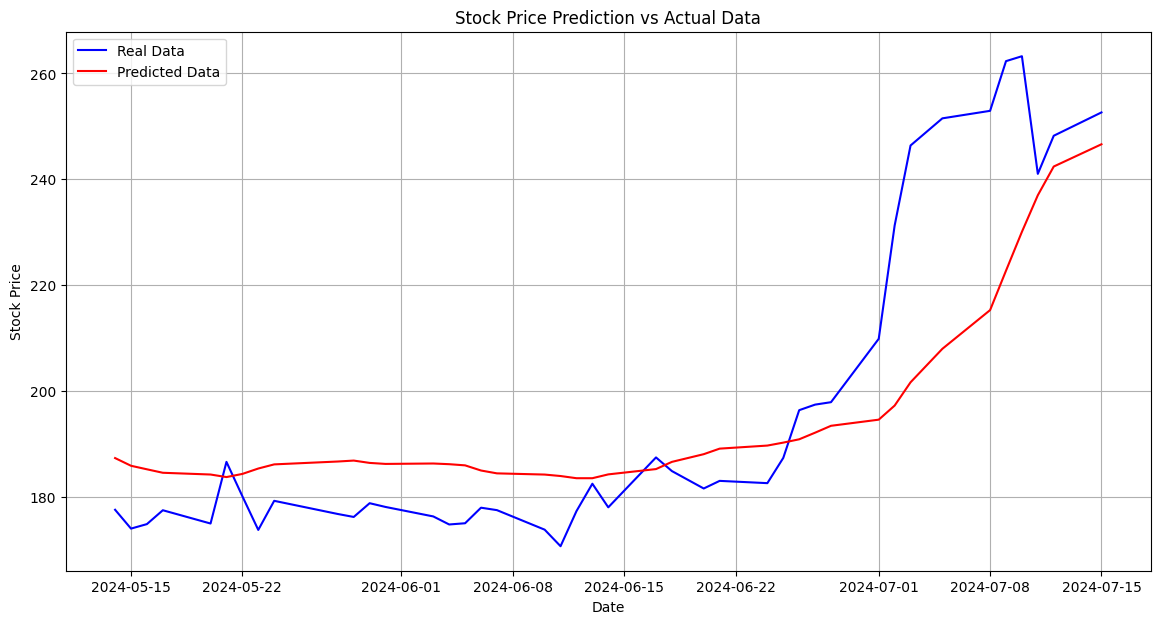

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='blue')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()



# Next 30 Days Forecast

In [ ]:
# Number of days to forecast
forecast_days = 30

# Prepare input data for forecasting
last_known_data = test_data[-look_back:]  # Last known data from the test set

# Prepare arrays to store forecast results
forecast_data = np.zeros((forecast_days, num_features))

# Perform forecasting
for i in range(forecast_days):
    # Predict next step
    next_step = model.predict(last_known_data.reshape(1, look_back, num_features))

    # Save the prediction
    forecast_data[i, -1] = next_step.flatten()

    # Update the input data for the next step
    last_known_data = np.roll(last_known_data, -1, axis=0)
    last_known_data[-1, -1] = next_step.flatten()

# Inverse transform the forecast data
forecast_data_original = scaler.inverse_transform(forecast_data)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-22-8373385fc4d5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_data[i, -1] = next_step.flatten()
<ipython-input-22-8373385fc4d5>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_data[-1, -1] = next_step.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

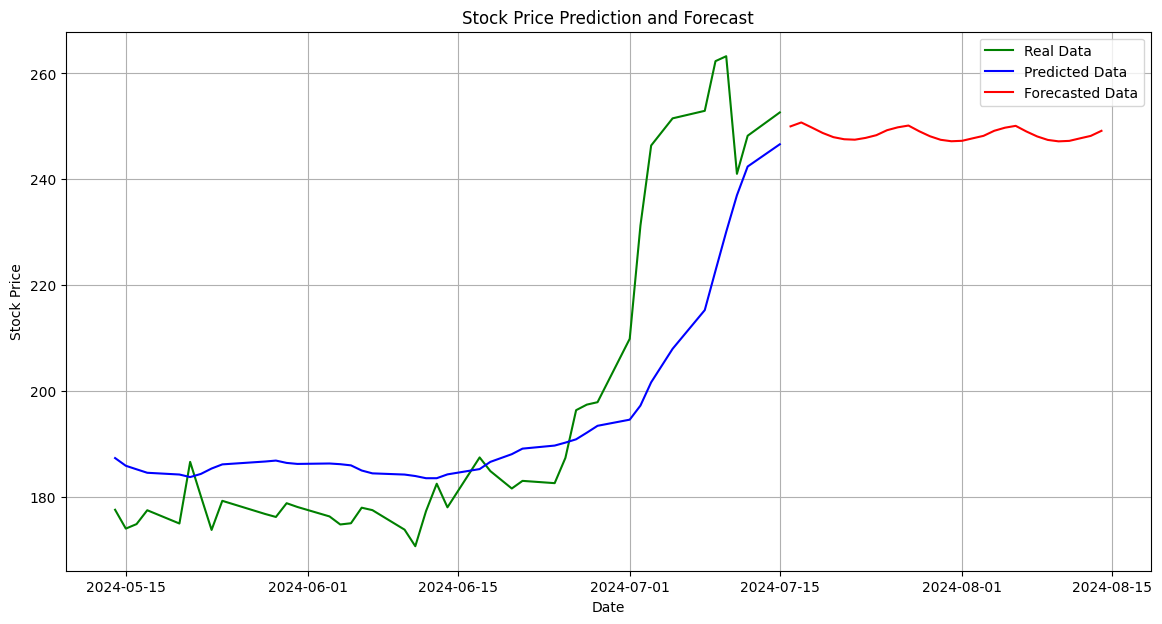

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


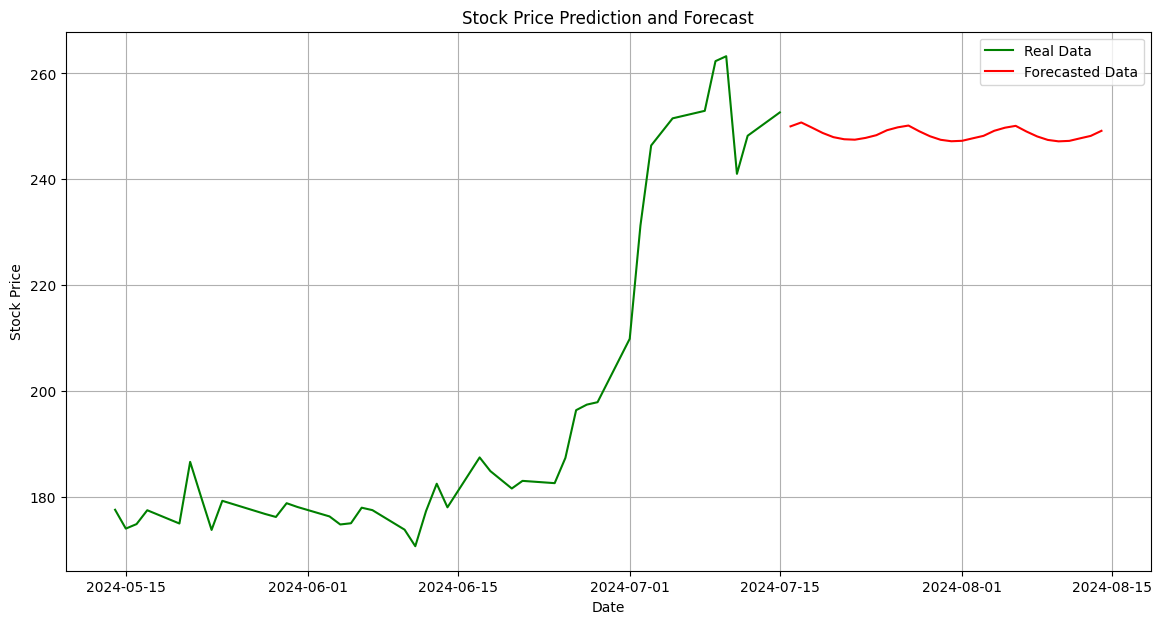

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot
plt.figure(figsize=(14,7))


# Plot the actual data
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


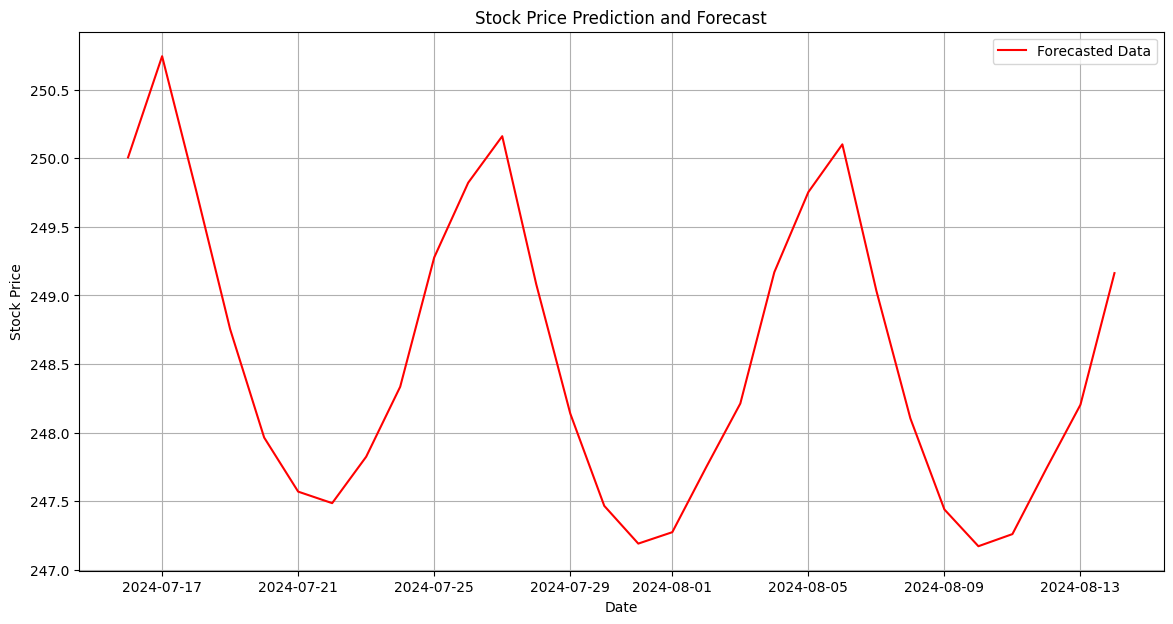

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the
plt.figure(figsize=(14,7))


# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


# Next 90 Days Forecast

In [ ]:
# Number of days to forecast
forecast_days = 90

# Prepare input data for forecasting
last_known_data = test_data[-look_back:]  # Last known data from the test set

# Prepare arrays to store forecast results
forecast_data = np.zeros((forecast_days, num_features))

# Perform forecasting
for i in range(forecast_days):
    # Predict next step
    next_step = model.predict(last_known_data.reshape(1, look_back, num_features))

    # Save the prediction
    forecast_data[i, -1] = next_step.flatten()

    # Update the input data for the next step
    last_known_data = np.roll(last_known_data, -1, axis=0)
    last_known_data[-1, -1] = next_step.flatten()

# Inverse transform the forecast data
forecast_data_original = scaler.inverse_transform(forecast_data)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-26-d52c3b6182da>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_data[i, -1] = next_step.flatten()
<ipython-input-26-d52c3b6182da>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_data[-1, -1] = next_step.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

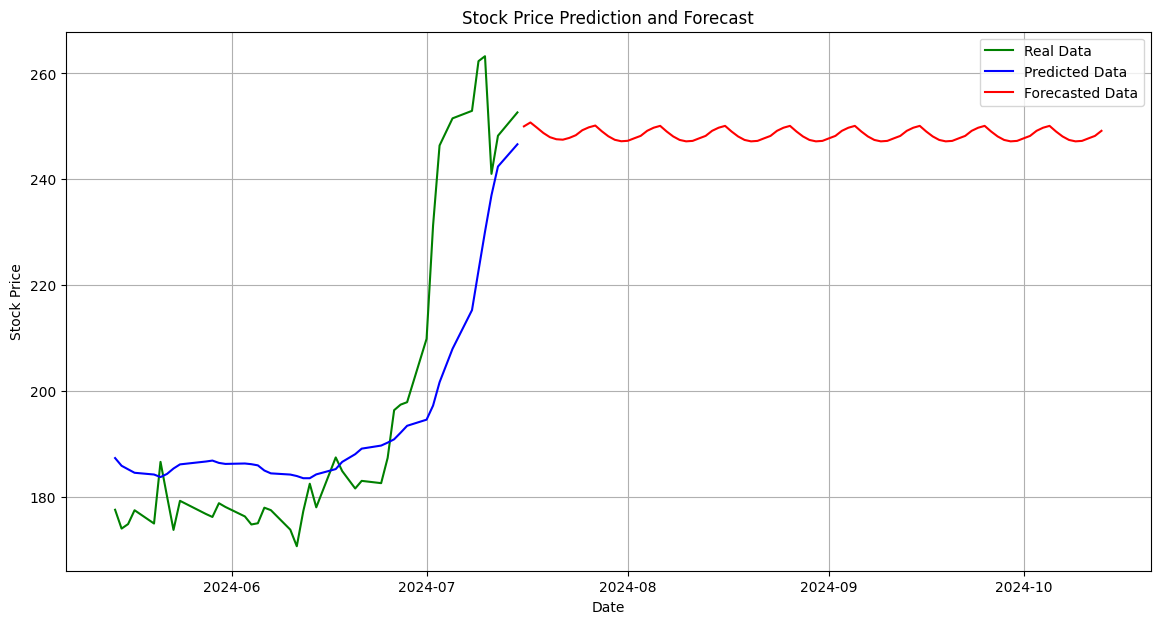

In [ ]:
# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the real test data
plt.figure(figsize=(14,7))
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the predicted data
plt.plot(dates, y_pred_original, label='Predicted Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


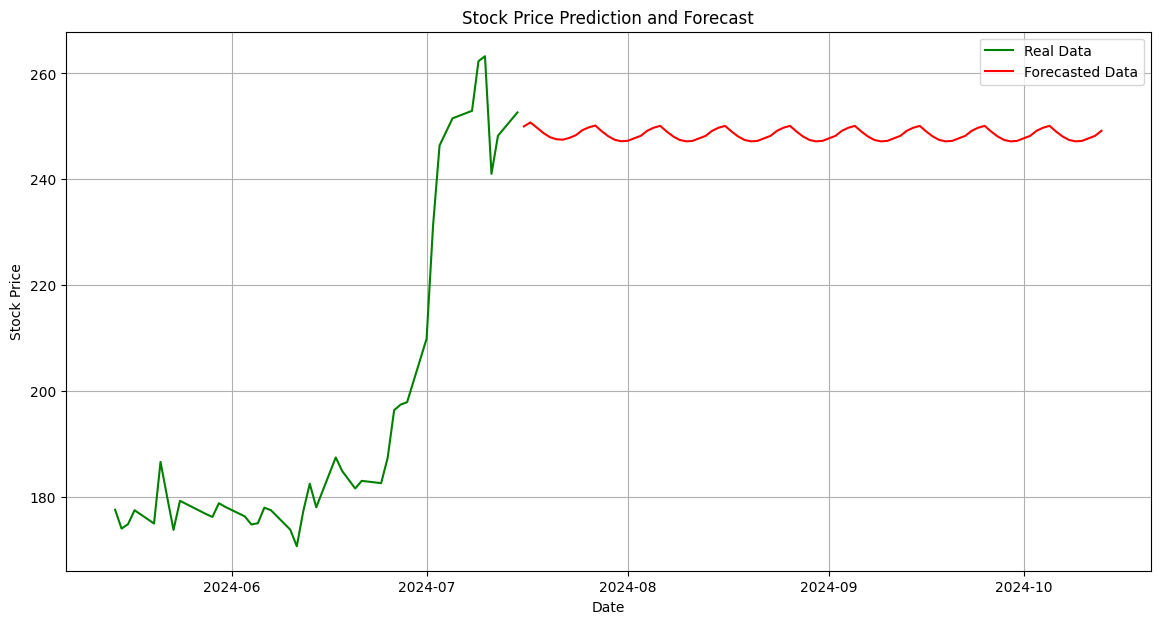

In [ ]:
plt.figure(figsize=(14,7))

# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

# Plot the actual data
plt.plot(dates, y_test_original, label='Real Data', color='green')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


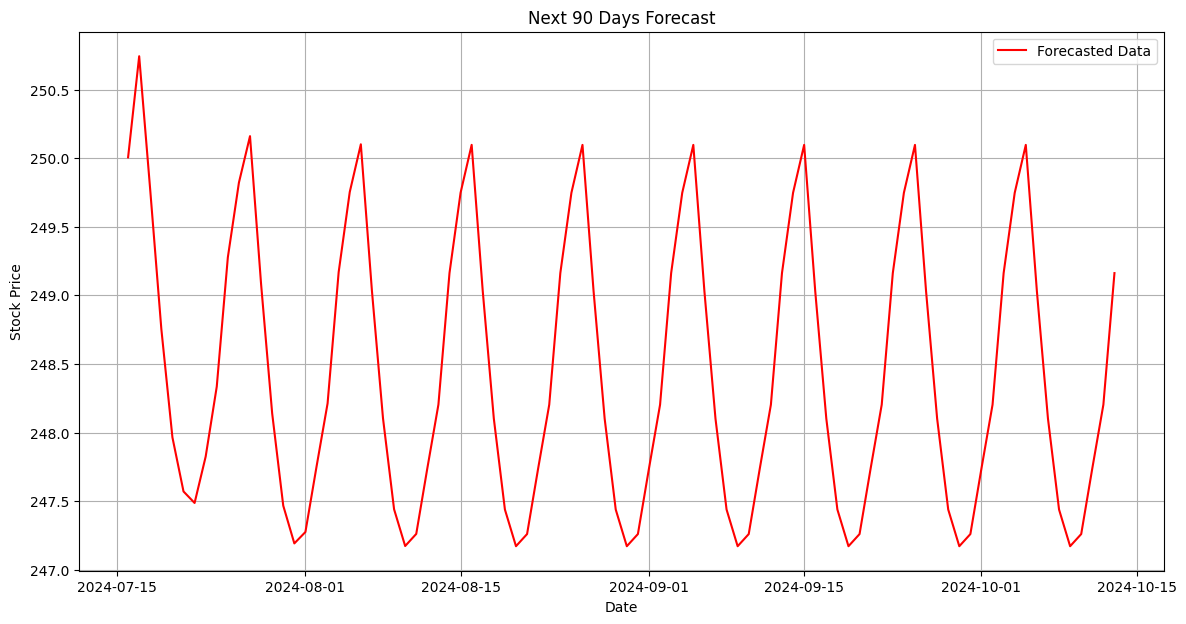

In [ ]:
plt.figure(figsize=(14,7))

# Extract the dates for plotting
dates = df.index[-len(y_test_original):]
forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)


# Plot the forecasted data
plt.plot(forecast_dates, forecast_data_original, label='Forecasted Data', color='red')

# Add titles and labels
plt.title('Next 90 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

# Show plot
plt.show()
